### Transformer Encoder Model

This notebook describes the approach taken to model the correctness of each student's future responses to problems encountered on the learning platform. Data of each student's interactions, consisting of how information about the exercise encountered and their respective responses, can be modelled in a sequential manner. 

This approach is similar to those used for text translation. 


In [1]:
# Import libraries 
import pandas as pd 
import numpy as np 
import re  
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import datetime as dt

In [2]:
# %% load data
data_dir = r'C:\Users\Timothy Lim\Desktop\junyi\archive'
info_content = pd.read_csv(os.path.join(data_dir, 'Info_Content.csv'))
info_userdata = pd.read_csv(os.path.join(data_dir, 'Info_UserData.csv'))
log_problem = pd.read_csv(os.path.join(data_dir, 'Log_Problem.csv'))

log_problem['timestamp_TW'] = log_problem['timestamp_TW'].apply(lambda x: dt.datetime.strptime(x[:-4], "%Y-%m-%d %H:%M:%S"))
log_problem.sort_values(by='timestamp_TW', ascending=True, inplace=True)
log_problem.head()

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
105021,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,9Ksy3bdm0HTi0D+cdKSBKDQJjo5GNahep91FqHUrpts=,2,1,True,8,1,0,False,NaN,NaN,0
11669798,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,/Wgjdl2BsldHZDdXXvzwGimusaMX548lqV2b7PgwXAs=,1,1,True,10,1,0,False,NaN,NaN,0
3768239,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,vsGlLPd9C58B8myBoGMGre2pDHjh62eRjsqX57D98fU=,5,1,True,6,1,0,False,False,True,1
10163558,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,hv7kHCAIdj7thZUmlqz553leG5bFNYgzXmLfB5m4Xvw=,h3CI/U4QJd6mjYE5xRH8QEst8lRG7otYIz+q1V6Och4=,5,1,True,5,1,0,False,False,True,1
8372688,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,OSuDd4rDo2muXXwwJRU2DQVHkk6/JOGgNzfzNi4PMJM=,3,1,True,4,1,0,False,NaN,NaN,0


Each feature will be represented using embeddings. The following features will be used as input to the model: 
* is_correct
* ucid (content id) 
* level 2 id (ucid may be different, but content may be similar) 
* time taken for previous qn 
* is hint used for previous qn
* problem_number (the n-th problem that the student encountered from this exercise) 

We will need to add 1 to each embedding column, as 0 will be used as the padding token. 

In [3]:
key_cols = ['timestamp_TW', 'uuid']
feature_cols = ['is_correct', 'ucid', 'upid', 'problem_number', 'total_sec_taken', 'is_hint_used']
df = log_problem[key_cols + feature_cols]

In [4]:
first_n = 100  # return first_n observations for each user 
user_log_problem = df.groupby(by='uuid').head(first_n)
user_log_problem

,timestamp_TW,uuid,is_correct,ucid,upid,problem_number,total_sec_taken,is_hint_used
105021,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,9Ksy3bdm0HTi0D+cdKSBKDQJjo5GNahep91FqHUrpts=,2,8,False
11669798,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,/Wgjdl2BsldHZDdXXvzwGimusaMX548lqV2b7PgwXAs=,1,10,False
3768239,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,vsGlLPd9C58B8myBoGMGre2pDHjh62eRjsqX57D98fU=,5,6,False
10163558,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,hv7kHCAIdj7thZUmlqz553leG5bFNYgzXmLfB5m4Xvw=,h3CI/U4QJd6mjYE5xRH8QEst8lRG7otYIz+q1V6Och4=,5,5,False
8372688,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,OSuDd4rDo2muXXwwJRU2DQVHkk6/JOGgNzfzNi4PMJM=,3,4,False
...,...,...,...,...,...,...,...,...
13360785,2019-07-31 23:45:00,90OCKSK8bkx4M+KdLllF8XNzykbJldJtxWaxQRuxPWY=,True,HXnIAxmCDEWAJJV2J7f2pEeGvddv9MpcRjbckar9YTY=,tvXS6hz6XdlgPmxZs3jfoX+saIvfhCzq8/D4gzrULeI=,5,364,False
13345074,2019-07-31 23:45:00,90OCKSK8bkx4M+KdLllF8XNzykbJldJtxWaxQRuxPWY=,True,HXnIAxmCDEWAJJV2J7f2pEeGvddv9MpcRjbckar9YTY=,uQDGUKEsX23MCS0xt/EDL7MhUW0kEPZeazOQSHVGsJg=,4,135,False
7960197,2019-07-31 23:45:00,90OCKSK8bkx4M+KdLllF8XNzykbJldJtxWaxQRuxPWY=,False,gQVxGCahF6+39K3glaRceVrND6A90VnDLSaj2NrTuis=,6M+OindLkGYAsjblVmm+OCNFhT2ch9OE1CWQofaIBYU=,1,436,True
14876381,2019-07-31 23:45:00,90OCKSK8bkx4M+KdLllF8XNzykbJldJtxWaxQRuxPWY=,True,HXnIAxmCDEWAJJV2J7f2pEeGvddv9MpcRjbckar9YTY=,Mo8JichdK3Bf2EAL96fRC9wWB/fXa67Bl9E7i2GLAnk=,7,93,False


In [5]:
# how many questions did each user take on average?
user_log_problem.groupby(by='uuid')['ucid'].count().describe()

count    72758.000000
mean        58.211949
std         39.532770
min          1.000000
25%         17.000000
50%         59.000000
75%        100.000000
max        100.000000
Name: ucid, dtype: float64

In [6]:
# add 1
user_log_problem['problem_number'] += 1
user_log_problem['is_hint_used'] += 1

# shift data
user_log_problem['total_sec_taken_shifted'] = user_log_problem[['uuid', 'total_sec_taken']].groupby('uuid')['total_sec_taken'].shift(1)
user_log_problem['is_hint_used_shifted'] = user_log_problem[['uuid', 'is_hint_used']].groupby('uuid')['is_hint_used'].shift(1)

# add question
user_log_problem['level2_id'] = user_log_problem.merge(info_content, how='left', on='ucid')['level2_id']
user_log_problem['level2_id'].fillna(method='ffill', inplace=True)

user_log_problem.head()

C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,timestamp_TW,uuid,is_correct,ucid,upid,problem_number,total_sec_taken,is_hint_used,total_sec_taken_shifted,is_hint_used_shifted,level2_id
105021,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,9Ksy3bdm0HTi0D+cdKSBKDQJjo5GNahep91FqHUrpts=,3,8,1,NaN,NaN,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=
11669798,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,/Wgjdl2BsldHZDdXXvzwGimusaMX548lqV2b7PgwXAs=,2,10,1,8.0,1.0,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=
3768239,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,vsGlLPd9C58B8myBoGMGre2pDHjh62eRjsqX57D98fU=,6,6,1,10.0,1.0,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=
10163558,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,hv7kHCAIdj7thZUmlqz553leG5bFNYgzXmLfB5m4Xvw=,h3CI/U4QJd6mjYE5xRH8QEst8lRG7otYIz+q1V6Och4=,6,5,1,6.0,1.0,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=
8372688,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,True,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,OSuDd4rDo2muXXwwJRU2DQVHkk6/JOGgNzfzNi4PMJM=,4,4,1,5.0,1.0,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=


In [7]:
user_log_problem.fillna(0, inplace=True)

user_log_problem.isna().any()

C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\pandas\core\frame.py:4465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


timestamp_TW               False
uuid                       False
is_correct                 False
ucid                       False
upid                       False
problem_number             False
total_sec_taken            False
is_hint_used               False
total_sec_taken_shifted    False
is_hint_used_shifted       False
level2_id                  False
dtype: bool

In [8]:
user_log_problem['is_correct'].value_counts(normalize=True)

True     0.721829
False    0.278171
Name: is_correct, dtype: float64

In [9]:
user_log_problem.columns

Index(['timestamp_TW', 'uuid', 'is_correct', 'ucid', 'upid', 'problem_number',
       'total_sec_taken', 'is_hint_used', 'total_sec_taken_shifted',
       'is_hint_used_shifted', 'level2_id'],
      dtype='object')

In [10]:
user_log_problem['is_correct'] = np.where(user_log_problem['is_correct'], 1.0, 0.0)
user_log_problem['is_correct'].value_counts(normalize=True)

C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1.0    0.721829
0.0    0.278171
Name: is_correct, dtype: float64

In [11]:
# make float, not sure if this makes a difference 
user_log_problem['problem_number'] = user_log_problem['problem_number'].astype(np.float64)

C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# one-hot encoding of categorical variables

from sklearn.preprocessing import OrdinalEncoder

def prep_categorical(cat_col):
    oe = OrdinalEncoder()
    cat_data = user_log_problem[cat_col].values.reshape(-1, 1)
    user_log_problem[cat_col] = oe.fit_transform(cat_data)
    
cat_cols = ['ucid', 'upid', 'level2_id']
for c in cat_cols:
    prep_categorical(c)

C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [13]:
# group rows by uuid and put in hashtable (dictionary)

user_dict = {uuid: u.drop(columns=['uuid', 'timestamp_TW', 'total_sec_taken', 'is_hint_used'])
             for uuid, u in user_log_problem.groupby('uuid')}

### Data Generator

* to feed data into the model, subclass tf.keras.utils.Sequence
* transform 2D tensor into 3D tensor, eg. [5,4] -> [5, 3, 4] if window_size=3

In [14]:
import tensorflow as tf

# helper functions

def rolling_window(a, w):
    s0, s1 = a.strides
    m, n = a.shape
    return np.lib.stride_tricks.as_strided(
        a, 
        shape=(m-w+1, w, n), 
        strides=(s0, s0, s1))

def make_time_series(x, windows_size):
  x = np.pad(x, [[ windows_size-1, 0], [0, 0]], constant_values=0)
  x = rolling_window(x, windows_size)
  return x 

def add_features_to_user(user):
    # We add one to the column in order to have zeros as padding values
    # Start Of Sentence (SOS) token will be 3. 
    user['is_correct'] = user['is_correct'].shift(fill_value=2)+1
    return user



In [15]:
class RiidSequence(tf.keras.utils.Sequence):
    def __init__(self, 
                 users, 
                 windows_size,
                 batch_size=256,
                 start=0,
                 end=None):
        self.users = users # {'user_id': user_df, ...}
        self.windows_size = windows_size
        
        # to convert indices to our keys
        self.mapper = dict(zip(range(len(users)), users.keys()))
        
        # start and end to easy generate training and validation
        self.start = start
        self.end = end if end else len(users)
        
        # To know where the is_correct_column is
        self.is_correct_index = list(self.user_example().columns).index('is_correct')
        
    def __len__(self):
        return self.end-self.start
    
    def __getitem__(self, idx):
        uid = self.mapper[idx+self.start]
        user = self.users[uid].copy()
        y = user['is_correct'].to_numpy().copy()
        x = add_features_to_user(user)
        return make_time_series(x, self.windows_size), y

    def user_example(self):
        """Just to check what we have till' now."""
        uid = self.mapper[self.start]
        return add_features_to_user(self.users[uid].copy())

      # INFERENCE PART    
    def get_user_for_inference(self, user_row):
        """Picks a new user row and concats it to previous interactions 
        if it was already stored.

        Maybe the biggest trick in the notebook is here. We reuse the user_id column to 
        insert the is_correct SOS token because we previously placed the column 
        there on purpose.

        After it, we roll that column and then crop it if it was bigger than the window
        size, making the SOS token disapear if out of the sequence.

        If the sequence if shorter than the window size, then we pad it.
        """
        uid = user_row[self.is_correct_index]
        user_row[self.is_correct_index] = 2 # SOS token
        user_row = user_row[np.newaxis, ...]
        if uid in self.users:
            x = np.concatenate([self.users[uid], user_row])
              # same as in training, we need to add one!!!
            x[:, self.is_correct_index] = np.roll(x[:, self.is_correct_index], 1) + 1
        else:
            x = user_row

        if x.shape[0] < self.windows_size:
            return np.pad(x, [[self.windows_size-x.shape[0], 0], [0, 0]])
        elif x.shape[0] > self.windows_size:
            return x[-self.windows_size:]
        else:
            return x
    def update_user(self, uid, user):
        """Concat the new user's interactions to the old ones if already stored."""
        if uid in self.users:
            self.users[uid] = np.concatenate([self.users[uid], user])[-self.windows_size:]
        else:
            self.users[uid] = user

In [16]:
RiidSequence(user_dict , windows_size=30).user_example().head()

,is_correct,ucid,upid,problem_number,total_sec_taken_shifted,is_hint_used_shifted,level2_id
10682047,3.0,693.0,23164.0,6.0,0.0,0.0,3.0
13798435,2.0,693.0,18315.0,4.0,7.0,1.0,9.0
5851364,2.0,693.0,24077.0,3.0,55.0,1.0,0.0
15461504,2.0,693.0,22244.0,5.0,17.0,1.0,9.0
11828870,2.0,693.0,12284.0,2.0,30.0,1.0,3.0


0 is the padding token. if first observation in sequence, **total_sec_taken_shifted** and **is_hint_used_shifted** are 0.

In [17]:
uuid = user_log_problem.loc[10682047]['uuid']
user_log_problem[user_log_problem['uuid']==uuid]

,timestamp_TW,uuid,is_correct,ucid,upid,problem_number,total_sec_taken,is_hint_used,total_sec_taken_shifted,is_hint_used_shifted,level2_id
10682047,2018-12-22 08:30:00,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,1.0,693.0,23164.0,6.0,7,1,0.0,0.0,3.0
13798435,2018-12-22 08:30:00,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,1.0,693.0,18315.0,4.0,55,1,7.0,1.0,9.0
5851364,2018-12-22 08:30:00,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,1.0,693.0,24077.0,3.0,17,1,55.0,1.0,0.0
15461504,2018-12-22 08:30:00,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,1.0,693.0,22244.0,5.0,30,1,17.0,1.0,9.0
11828870,2018-12-22 08:30:00,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,1.0,693.0,12284.0,2.0,193,1,30.0,1.0,3.0


In [18]:
x, y = RiidSequence(user_dict, windows_size=30)[0]
x.shape, y.shape

((5, 30, 7), (5,))

In [19]:
x[-1][-5:]

array([[3.0000e+00, 6.9300e+02, 2.3164e+04, 6.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00],
       [2.0000e+00, 6.9300e+02, 1.8315e+04, 4.0000e+00, 7.0000e+00,
        1.0000e+00, 9.0000e+00],
       [2.0000e+00, 6.9300e+02, 2.4077e+04, 3.0000e+00, 5.5000e+01,
        1.0000e+00, 0.0000e+00],
       [2.0000e+00, 6.9300e+02, 2.2244e+04, 5.0000e+00, 1.7000e+01,
        1.0000e+00, 9.0000e+00],
       [2.0000e+00, 6.9300e+02, 1.2284e+04, 2.0000e+00, 3.0000e+01,
        1.0000e+00, 3.0000e+00]])

In [20]:
y

array([1., 1., 1., 1., 1.])

#### Modelling part

https://www.tensorflow.org/tutorials/text/transformer

In [21]:

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# NN THINGS
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
    return output, attention_weights

    
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask) 
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output) 

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) 

        return out2
    
def create_padding_mask(seqs):
  # We mask only those vectors of the sequence in which we have all zeroes 
  # (this is more scalable for some situations).
    mask = tf.cast(tf.reduce_all(tf.math.equal(seqs, 0), axis=-1), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [22]:
columns = list(RiidSequence(user_dict, 30).user_example().columns)
columns

['is_correct',
 'ucid',
 'upid',
 'problem_number',
 'total_sec_taken_shifted',
 'is_hint_used_shifted',
 'level2_id']

In [23]:
def get_series_model(
    n_features,
    n_ucid, n_upid, n_problem_num,
    n_prev_time_taken, n_prev_hint_used,
    n_level2_id,
    windows_size=30,
    d_model=24,
    num_heads=4,
    n_encoder_layers = 2
    ):
    # Input
    inputs = tf.keras.Input(shape=(windows_size, n_features), name='inputs')
    mask = create_padding_mask(inputs)
    pos_enc = positional_encoding(windows_size, d_model)    
    
    # Divide branches
    is_correct = inputs[..., 0]
    ucid = inputs[..., 1]
    upid = inputs[..., 2]
    problem_number = inputs[..., 3]
    prev_time_taken = inputs[..., 4]
    prev_hint_used = inputs[..., 5]
    level2_id = inputs[..., 6]
    
    # Create embeddings
    ucid_embeddings = tf.keras.layers.Embedding(n_ucid, d_model)(ucid)
    upid_embeddings = tf.keras.layers.Embedding(n_upid, d_model)(upid)
    problem_number_embeddings = tf.keras.layers.Embedding(n_problem_num, d_model)(problem_number)
    prev_time_taken_embeddings = tf.keras.layers.Embedding(n_prev_time_taken, d_model)(prev_time_taken)
    prev_hint_used_embeddings = tf.keras.layers.Embedding(n_prev_hint_used, d_model)(prev_hint_used)
    level2_id_embeddings = tf.keras.layers.Embedding(n_level2_id, d_model)(level2_id)

    is_correct_embeddings = tf.keras.layers.Embedding(4, d_model)(is_correct)
    
    # Continuous! Only a learnable layer for it.
    # elapsed_time_embeddings = tf.keras.layers.Dense(d_model, use_bias=False)(elapsed_time)
    # part_embeddings = tf.keras.layers.Embedding(part_ids, d_model)(part)
    
    # Add embeddings
    x = tf.keras.layers.Add()([
        pos_enc,
        ucid_embeddings,
        upid_embeddings,
        problem_number_embeddings,
        prev_time_taken_embeddings, 
        prev_hint_used_embeddings,
        level2_id_embeddings,
        is_correct_embeddings
    ])

    for _ in range(n_encoder_layers):
        x = EncoderLayer(d_model=d_model, num_heads=num_heads, dff=d_model*4, rate=0.1)(x, mask=mask)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.2)(x) 
    
    # only 1 output, which is the probability of getting the question correct..? 
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)
    return tf.keras.Model(inputs, output, name='model')

#### Training

In [24]:
train_idx = int(len(user_dict)*0.8)
windows_size = 30
epochs = 300
patience = 2
d_model = 32
num_heads = 4
n_encoder_layers = 3

In [25]:
info_content

,ucid,content_pretty_name,content_kind,difficulty,subject,learning_stage,level1_id,level2_id,level3_id,level4_id
0,odIwFdIiecFwVUAEEV40K3MSuCSlIZkbq92Zp9tkZq8=,【基礎】怎樣解題：數量關係,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
1,dfeeBaa8zDhWS6nu7zeXKwLyi4zqEajI3tJM9/fSBPM=,【基礎】和差問題 1,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
2,C2AT0OBTUn+PRxEVd39enhW/DJtka1Tk90DUAR6yVdA=,【基礎】雞兔問題 1,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
3,jZvYpEa6VB/WrlKKmQHnfbv/xJ4OypBzq0epVcn500Q=,【基礎】年齡問題 1,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
4,M+UxJPgRIW57a0YS3eik8A9YDj+AwaMpTa5yWYn/kAw=,【基礎】追趕問題,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
...,...,...,...,...,...,...,...,...,...,...
1325,NPkrCjbLK35wefMCv6y6XMO5eYO/gthS6LGwrdjG2OQ=,【進階】平方公分綜合習題,Exercise,hard,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=,8OFhw5s0EmQIKBlKbJL+Dvp+u3ss4rN3foLwLM4xXls=,JtYpwXqNWwRqPrXYh0JhE2lEEUI1gKRPdDH3jYwhqMo=
1326,3xqxJN2W+KEo3SBjh7HnXpGjB4ewSbm1j/18fCn05yc=,【進階】周長與面積綜合習題,Exercise,hard,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=,8OFhw5s0EmQIKBlKbJL+Dvp+u3ss4rN3foLwLM4xXls=,Ny1/uHUXA4pvWVN1nVWv+vsdaQde7StyoQV8HAyJD80=
1327,j4rGpwpqhLE9foelXD2yjokS0u3QR+ULhNqLGeF/4sk=,【一般】平方公分綜合習題,Exercise,normal,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=,8OFhw5s0EmQIKBlKbJL+Dvp+u3ss4rN3foLwLM4xXls=,JtYpwXqNWwRqPrXYh0JhE2lEEUI1gKRPdDH3jYwhqMo=
1328,W4l0TIo0YQXLT/c8/Uy7OLtElmNuNWPODI7HkJ0NaI0=,【一般】周長與面積綜合習題,Exercise,normal,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=,8OFhw5s0EmQIKBlKbJL+Dvp+u3ss4rN3foLwLM4xXls=,Ny1/uHUXA4pvWVN1nVWv+vsdaQde7StyoQV8HAyJD80=


In [26]:
s_train = RiidSequence(user_dict, windows_size, start=0, end=train_idx)
s_val = RiidSequence(user_dict, windows_size, start=train_idx)

# init variables
n_features = s_train[0][0].shape[-1]
ucids = info_content['ucid'].nunique()
upids = user_log_problem['upid'].nunique()

# might need to clip these next time
problem_numbers = int(user_log_problem['problem_number'].max() + 1)
prev_times_taken = user_log_problem['total_sec_taken'].max() + 1
prev_hints_used = 3
level2_ids = user_log_problem['level2_id'].nunique()

tf.keras.backend.clear_session()
model = get_series_model(
        n_features,
        ucids, upids, problem_numbers,
        prev_times_taken, prev_hints_used,
        level2_ids,
        windows_size=windows_size,
        d_model=d_model,
        num_heads=num_heads,
        n_encoder_layers=n_encoder_layers
    )

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[tf.keras.metrics.AUC(name='AUC'), tf.keras.metrics.BinaryAccuracy(name='acc')]
)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 30, 7)]      0                                            
__________________________________________________________________________________________________
tf.math.equal (TFOpLambda)      (None, 30, 7)        0           inputs[0][0]                     
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 30)           0           inputs[0][0]                     
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 30)           0           inputs[0][0]                     
______________________________________________________________________________________________

In [29]:
s_train.user_example().dtypes

is_correct                 float64
ucid                       float64
upid                       float64
problem_number             float64
total_sec_taken_shifted    float64
is_hint_used_shifted       float64
level2_id                  float64
dtype: object

i think i need to encode the categorical variables first

In [30]:
train = False
if train:
    model.fit(
        s_train,
        validation_data=s_val,
        epochs=50,
        shuffle=True,
        use_multiprocessing=False,  # my machine doesnt support this i think
        callbacks=tf.keras.callbacks.EarlyStopping(patience=patience, 
                                                   monitor='val_acc',
                                                   mode='max', 
                                                   restore_best_weights=True)
    )
    model.save_weights('model.h5')

In [31]:
s_val.user_example().head()

,is_correct,ucid,upid,problem_number,total_sec_taken_shifted,is_hint_used_shifted,level2_id
12675869,3.0,1320.0,20701.0,5.0,0.0,0.0,9.0
3291425,1.0,1320.0,20331.0,8.0,58.0,2.0,6.0
4391198,2.0,1320.0,8628.0,4.0,34.0,1.0,9.0
776530,2.0,1320.0,11917.0,2.0,32.0,1.0,3.0
14014242,2.0,1320.0,20628.0,3.0,35.0,1.0,3.0


In [32]:
log_problem.loc[12675869]

timestamp_TW                                                2019-01-06 16:45:00
uuid                               nGDS5NP4sPacGBoq0wkKGqlLNtjeW1aQHzwMRJsbX2g=
ucid                               zX5HAUpRYC4F7YPNs5tUeBqVi++rEmPUfsAtHpoZmEQ=
upid                               o9WNwjME352ccMlhldfl1g38KX6YxiM0u10RXJdpmn4=
problem_number                                                                4
exercise_problem_repeat_session                                               1
is_correct                                                                False
total_sec_taken                                                              58
total_attempt_cnt                                                             3
used_hint_cnt                                                                 1
is_hint_used                                                               True
is_downgrade                                                                NaN
is_upgrade                              

In [33]:
# load model weights
model.load_weights("model.h5")

# run prediction on val set
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.AUC(name='AUC'), 
                       tf.keras.metrics.BinaryAccuracy(name='acc')])
model.evaluate(s_val)

14552/14552 [==============================] - 296s 20ms/step - loss: 0.4711 - AUC: 0.7970 - acc: 0.7788


[0.4721461236476898, 0.7982720732688904, 0.7784760594367981]

In [34]:
# Make x_tmp, the first observation in the validation set
x_tmp, y_tmp = s_val.__getitem__(2)
y_prob = model.predict(x_tmp, batch_size=x_tmp.shape[0])

In [35]:
# convert probabilities to predictions
cutoff = 0.5
y_pred = [e for x in y_prob for e in x]
y_pred = np.where(np.array(y_pred) >= cutoff, 1, 0)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_tmp, y_pred)
print(acc)

0.8


In [36]:
y_tmp

array([1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [37]:
y_pred

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [41]:
# get predictions for all the observations
y_prob = model.predict(s_val, batch_size=s_val.__len__())

In [47]:
# get actual values
y_true = []
for i in range(s_val.__len__()):
    y_true.extend(s_val.__getitem__(i)[1])

print(len(y_true))

847931


In [48]:
len(y_prob)

847931

In [50]:
y_pred = [e for x in y_prob for e in x]
y_pred = np.where(np.array(y_pred) >= cutoff, 1, 0)

accuracy_score(y_true, y_pred)

0.7784760788318861

Text(33.0, 0.5, 'Actual')

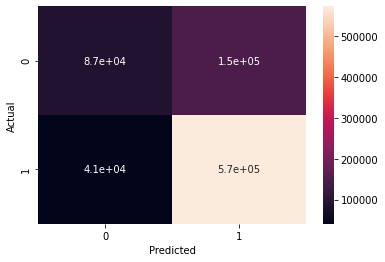

In [62]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [63]:
from sklearn.metrics import precision_score, recall_score

# precision and recall for students that answer questions wrongly
precision = precision_score(y_true, y_pred, pos_label=0)
recall = recall_score(y_true, y_pred, pos_label=0)

print(f'precision: {precision}')
print(f'recall: {recall}')

precision: 0.6795926207594063
recall: 0.3709822383907554


In [64]:
# precision and recall for students that answer questions correctly
precision = precision_score(y_true, y_pred, pos_label=1)
recall = recall_score(y_true, y_pred, pos_label=1)

print(f'precision: {precision}')
print(f'recall: {recall}')

precision: 0.7959838086353944
recall: 0.9334718150162548


precision => among the observations predicted as positive, how many of those were actually positive? 

recall => among those observations that are actually positive, how many were predicted as positive? 


so we can see that our classifier might not be that strong in predicting if students are really going to get the question wrong. 

In [78]:
pd.Series(y_true, index=np.arange(0, len(y_true))).value_counts(normalize=True)

1.0    0.724447
0.0    0.275553
dtype: float64

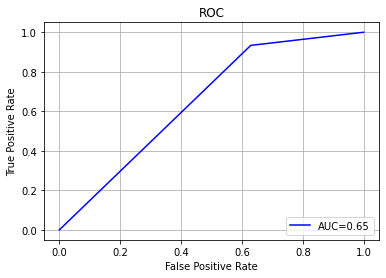

In [75]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.title("ROC")
plt.plot(fpr, tpr, 'b', label='AUC=%0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(True)